#Import

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 13.7 MB/s 
     |████████████████████████████████| 895 kB 50.3 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 6.5 MB 48.6 MB/s 
     |████████████████████████████████| 596 kB 64.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import logging
from matplotlib import pyplot as plt

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
!/opt/bin/nvidia-smi

Mon Mar 21 07:10:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    13W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

#read dataset

##988

In [ ]:


train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/4192/Data/DirectCompare/train_df.csv")

train_df = train_df[['selftext','Expert-label']]
train_df[['Expert-label']] = train_df[['Expert-label']].astype(int)
train_df

,selftext,Expert-label
0,I posted this on Piazza but thought I might as...,1
1,"Hi i’ve applied for arts from Vancouver,BC as ...",0
2,i'm an international student and i've been tak...,1
3,i'm an international student and the midterm w...,1
4,they think i wouldnt be able to handle the str...,0
...,...,...
997,My boyfriend is Canadian and I’m American. Obv...,0
998,Do you need to be vaccinated to travel domesti...,0
999,"Hello, are there any International students he...",1
1000,Will you guys take a leave of absence? Or are ...,0


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/4192/Data/Validation988/988validation.csv")

test_df = test_df[['selftext']]
test_df.insert(test_df.shape[1], 'label', 1)
test_df

,selftext,label
0,Well... I think I need some help... about depr...,1
1,I am an international student and i started en...,1
2,i'm an international student and the midterm w...,1
3,"Honestly just want to end it all , it’s so har...",1
4,"Hi all, \n\nI'm really upset to know the Winte...",1
...,...,...
983,WE NEED A SCIENCE AND DATA BASED APPROACH TO C...,1
984,Hi everyone! Hope that all who are applying ar...,1
985,Hello everyone !\n\nI request some advice from...,1
986,"Hi, I was wondering what my chances were at th...",1


In [ ]:
test_data = test_df['selftext'].values.tolist()

In [ ]:
train_list=[]
train_20 = train_df.iloc[:200]
train_40 = train_df.iloc[:400]
train_60 = train_df.iloc[:600]
train_80 = train_df.iloc[:800]


train_list.append(train_20)
train_list.append(train_40)
train_list.append(train_60)
train_list.append(train_80)
train_list.append(train_df)

##tss

In [ ]:
from sklearn.model_selection import train_test_split

train_df_tss = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/project/4192/Data/DirectCompare/train_df.csv")

train_df_tss = train_df_tss[['selftext','Expert-label']]
train_df_tss[['Expert-label']] = train_df_tss[['Expert-label']].astype(int)

X = train_df_tss["selftext"].values.tolist()
y = train_df_tss["Expert-label"].values.tolist()


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=0)


In [ ]:
train_list_tss=[]

train_20_tss = X_train[:200]
train_40_tss = X_train[:400]
train_60_tss = X_train[:600]


train_list_tss.append(train_20_tss)
train_list_tss.append(train_40_tss)
train_list_tss.append(train_60_tss)
train_list_tss.append(X_train)

train_label_tss=[]

label_20_tss = y_train[:200]
label_40_tss = y_train[:400]
label_60_tss = y_train[:600]


train_label_tss.append(label_20_tss)
train_label_tss.append(label_40_tss)
train_label_tss.append(label_60_tss)
train_label_tss.append(y_train)

##torch dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])



##Metrics

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

#SciBERT

##988

In [ ]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )

recall_list=[]

X_val = test_df["selftext"].values.tolist()
y_val = test_df["label"].values.tolist()
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
val_dataset = Dataset(X_val_tokenized, y_val)


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

In [ ]:
for i in train_list:

  tokenizer = BertTokenizer.from_pretrained(model_name)
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )


  X_train = i["selftext"].values.tolist()
  y_train = i["Expert-label"].values.tolist()
  X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
  train_dataset = Dataset(X_train_tokenized, y_train)

  args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    seed=0,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16

    
  )

  trainer_sci = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  
  
  )

  trainer_sci.train()
  res = trainer_sci.evaluate()
  recall_list.append(res['eval_recall'])

loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,1.777393,0.000000,0.000000,0.000000,0.000000
1,No log,1.843297,0.000000,0.000000,0.000000,0.000000
2,No log,1.845726,0.000000,0.000000,0.000000,0.000000


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to c

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_sci

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,1.380034,0.096154,1.000000,0.096154,0.175439
1,No log,1.563380,0.091093,1.000000,0.091093,0.166976
2,No log,1.403170,0.140688,1.000000,0.140688,0.246673


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,0.930266,0.315789,1.000000,0.315789,0.480000
1,No log,1.231984,0.146761,1.000000,0.146761,0.255958
2,No log,1.503397,0.090081,1.000000,0.090081,0.165274


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.198618,0.178138,1.000000,0.178138,0.302405
2,No log,1.425952,0.183198,1.000000,0.183198,0.309666
3,No log,1.755382,0.160931,1.000000,0.160931,0.277245


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,0.885952,0.288462,1.000000,0.288462,0.447761
1,No log,1.320527,0.096154,1.000000,0.096154,0.175439
2,No log,1.472891,0.181174,1.000000,0.181174,0.306769


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2
***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 988
  Batch size = 2


##tss

In [ ]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )

recall_list_tss=[]
acc_list_tss=[]
pre_list_tss=[]


X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
val_dataset = Dataset(X_val_tokenized, y_val)


Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

In [ ]:
for i in range(len(train_list_tss)):

  tokenizer = BertTokenizer.from_pretrained(model_name)
  model = BertForSequenceClassification.from_pretrained(model_name,num_labels =2 )


  X_train = train_list_tss[i]
  y_train = train_label_tss[i]
  X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
  train_dataset = Dataset(X_train_tokenized, y_train)

  args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    seed=0,
    overwrite_output_dir=True,
    learning_rate=3e-5,
    gradient_accumulation_steps=16

    
  )

  trainer_sci = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  
  
  )

  trainer_sci.train()
  res = trainer_sci.evaluate()
  recall_list_tss.append(res['eval_recall'])
  acc_list_tss.append(res['eval_accuracy'])
  pre_list_tss.append(res['eval_precision'])

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,0.662617,0.577114,0.559524,0.494737,0.525140
1,No log,0.679320,0.582090,0.547009,0.673684,0.603774
2,No log,0.689461,0.567164,0.533898,0.663158,0.591549


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,0.667405,0.537313,0.506757,0.789474,0.617284
1,No log,0.674292,0.557214,1.000000,0.063158,0.118812
2,No log,0.657699,0.567164,0.540000,0.568421,0.553846


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,0.672764,0.527363,0.500000,0.473684,0.486486
1,No log,0.661286,0.562189,0.539326,0.505263,0.521739
2,No log,0.646449,0.592040,0.559633,0.642105,0.598039


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/33593020f507d72099bd84ea6cd2296feb424fecd62d4a8edcc2a02899af6e29.38339d84e6e392addd730fd85fae32652c4cc7c5423633d6fa73e5f7937bbc38
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json from cache at None
loading configuration file https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/858852fd2471ce39075378592ddc87f5a6551e64c6825d1b92c8dab9318e0fc3.03ff9e9f998b9a9d40647a2148a202e3fb3d568dc0f170dda9dda194bab4d5dd
Model config BertConfig {
  "_name_or_path": "allenai/scibert_scivoca

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,No log,0.672256,0.567164,0.526667,0.831579,0.644898
1,No log,0.656920,0.611940,0.571429,0.715789,0.635514
2,No log,0.648091,0.641791,0.590551,0.789474,0.675676


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2
***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 201
  Batch size = 2


#Result

##988

In [ ]:
recall_list

[0.0,
 0.14068825910931174,
 0.09008097165991903,
 0.16093117408906882,
 0.1811740890688259]

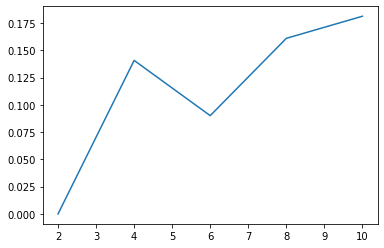

In [ ]:
plt.plot(range(2,11,2),recall_list)

In [ ]:
#p_1 = (recall_list[1]-recall_list[0])/recall_list[0]
p_2 = (recall_list[2]-recall_list[1])/recall_list[1]
p_3 = (recall_list[3]-recall_list[2])/recall_list[2]
p_4 = (recall_list[4]-recall_list[3])/recall_list[3]
p_5 = (recall_list[4]-recall_list[1])/recall_list[1]
#print('First progress: ' +str(p_1))
print('Second progress: ' +str(p_2))
print('Third progress: ' +str(p_3))
print('Fourth progress: ' +str(p_4))
print('Final progress: ' +str(p_5))

Second progress: -0.35971223021582727
Third progress: 0.7865168539325841
Fourth progress: 0.12578616352201255
Final progress: 0.28776978417266186


##tss

In [ ]:
recall_list_tss,acc_list_tss,pre_list_tss

([0.6631578947368421,
  0.5684210526315789,
  0.6421052631578947,
  0.7894736842105263],
 [0.5671641791044776,
  0.5671641791044776,
  0.5920398009950248,
  0.6417910447761194],
 [0.5338983050847458, 0.54, 0.5596330275229358, 0.5905511811023622])

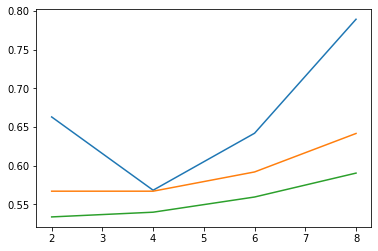

In [ ]:
plt.plot(range(2,9,2),recall_list_tss)
plt.plot(range(2,9,2),acc_list_tss)
plt.plot(range(2,9,2),pre_list_tss)

In [ ]:
p_1_t = (recall_list_tss[1]-recall_list_tss[0])/recall_list_tss[0]
p_2_t = (recall_list_tss[2]-recall_list_tss[1])/recall_list_tss[1]
p_3_t = (recall_list_tss[3]-recall_list_tss[2])/recall_list_tss[2]
p_4_t = (recall_list_tss[3]-recall_list_tss[0])/recall_list_tss[0]

print('First progress: ' +str(p_1_t))
print('Second progress: ' +str(p_2_t))
print('Third progress: ' +str(p_3_t))
print('Final progress: ' +str(p_4_t))

First progress: -0.14285714285714282
Second progress: 0.12962962962962965
Third progress: 0.2295081967213115
Final progress: 0.19047619047619058


In [ ]:
p_1_t = (acc_list_tss[1]-acc_list_tss[0])/acc_list_tss[0]
p_2_t = (acc_list_tss[2]-acc_list_tss[1])/acc_list_tss[1]
p_3_t = (acc_list_tss[3]-acc_list_tss[2])/acc_list_tss[2]
p_4_t = (acc_list_tss[3]-acc_list_tss[0])/acc_list_tss[0]

print('First progress: ' +str(p_1_t))
print('Second progress: ' +str(p_2_t))
print('Third progress: ' +str(p_3_t))
print('Final progress: ' +str(p_4_t))

First progress: 0.0
Second progress: 0.043859649122807015
Third progress: 0.08403361344537814
Final progress: 0.13157894736842105


In [ ]:
p_1_t = (pre_list_tss[1]-pre_list_tss[0])/pre_list_tss[0]
p_2_t = (pre_list_tss[2]-pre_list_tss[1])/pre_list_tss[1]
p_3_t = (pre_list_tss[3]-pre_list_tss[2])/pre_list_tss[2]
p_4_t = (pre_list_tss[3]-pre_list_tss[0])/pre_list_tss[0]

print('First progress: ' +str(p_1_t))
print('Second progress: ' +str(p_2_t))
print('Third progress: ' +str(p_3_t))
print('Final progress: ' +str(p_4_t))

First progress: 0.011428571428571456
Second progress: 0.03635745837580689
Third progress: 0.055247192461597996
Final progress: 0.10611173603299574
